In [1]:
# concatenate the data frames together
import glob
import numpy as np
import pandas as pd

npzfile = np.load("map.npz")
x_map = npzfile['arr_0']
y_map = npzfile['arr_1']
waypoints_map = npzfile['arr_2']

files = glob.glob('Data_Collection_new_controller_*.pd')
df = []
j = 1
for fp in files:
    print(j)
    j += 1
    current_dataframe = pd.read_pickle(fp)
    x = np.array(current_dataframe['x-loc(m)'])
    y = np.array(current_dataframe['y-loc(m)'])
    theta = np.array(current_dataframe['theta(radians)'])
    t = np.array(current_dataframe['Ticks(s)'])
    v = np.array(current_dataframe['speed(m/s)'])
    d = np.array(current_dataframe['d'])
    u = np.array(current_dataframe['input'])
    # calculate cte and theta from map
    theta_local = []
    cte = []
    theta_track = []
    for i in range(x.shape[0]):
        distance = np.linalg.norm(waypoints_map - np.array([x[i], y[i]]), axis=1)
        index_tp = np.argmin(distance)
        if index_tp < x_map.shape[0] - 1:
            waypoint_vector_x = x_map[index_tp + 1] - x_map[index_tp]
            waypoint_vector_y = y_map[index_tp + 1] - y_map[index_tp]
            theta_waypoint = np.arctan2(waypoint_vector_y, waypoint_vector_x)
            theta_local.append(theta[i] - theta_waypoint)
            theta_track.append(theta_waypoint)
            start_waypoint_to_car_location_x = x[i] - x_map[index_tp]
            start_waypoint_to_car_location_y = y[i] - y_map[index_tp]
            area = -(start_waypoint_to_car_location_x * waypoint_vector_y - start_waypoint_to_car_location_y * waypoint_vector_x) / 2
            cte.append(area / np.linalg.norm(np.array([waypoint_vector_x, waypoint_vector_y]), axis=0))
        else:
            waypoint_vector_x = x_map[index_tp] - x_map[index_tp - 1]
            waypoint_vector_y = y_map[index_tp] - y_map[index_tp - 1]
            theta_waypoint = np.arctan2(waypoint_vector_y, waypoint_vector_x)
            theta_local.append(theta[i] - theta_waypoint)
            theta_track.append(theta_waypoint)
            start_waypoint_to_car_location_x = x[i] - x_map[index_tp]
            start_waypoint_to_car_location_y = y[i] - y_map[index_tp]
            area = -(start_waypoint_to_car_location_x * waypoint_vector_y - start_waypoint_to_car_location_y * waypoint_vector_x) / 2
            cte.append(area / np.linalg.norm(np.array([waypoint_vector_x, waypoint_vector_y]), axis=0))
    theta_local = np.array(theta_local)
    theta_track = np.array(theta_track)
    theta_local[theta_local > 3.1415926] = theta_local[theta_local > 3.1415926] - 3.1415926
    theta_local[theta_local > 3] = theta_local[theta_local > 3] - 3.1415926
    theta_local[theta_local < -3.1415926] = theta_local[theta_local < -3.1415926] + 3.1415926
    theta_local[theta_local < -3] = theta_local[theta_local < -3] + 3.1415926
    dtheta_track = np.diff(theta_track)
    dtheta_track[dtheta_track > 3.1415926] = dtheta_track[dtheta_track > 3.1415926] - 3.1415926
    dtheta_track[dtheta_track > 3] = dtheta_track[dtheta_track > 3] - 3.1415926
    dtheta_track[dtheta_track < -3.1415926] = dtheta_track[dtheta_track < -3.1415926] + 3.1415926
    dtheta_track[dtheta_track < -3] = dtheta_track[dtheta_track < -3] + 3.1415926
    dtheta_track = np.divide(dtheta_track, np.diff(t))
    dtheta_track = dtheta_track.tolist()
    dtheta_track.append(0)
    current_dataframe['cte'] = cte
    current_dataframe['theta_e'] = theta_local.tolist()
    current_dataframe['dphi_t'] = dtheta_track
    # calculate the error between dynamics and model
    dcte_true = np.divide(np.diff(np.array(cte)), np.diff(t))
    dcte_predict = np.multiply(v, np.sin(theta_local))[0:-1]
    dv_true = np.divide(np.diff(v), np.diff(t))
    dv_predict = (- 1.0954 * v - 0.007 * np.multiply(v, v) - 0.1521 * d + 3.7387)[0:-1]
    dd_true = np.divide(np.diff(d), np.diff(t))
    dd_predict = (3.6 * v - 20)[0:-1]
    dtheta_e_true = np.divide(np.diff(theta_local), np.diff(t))
    dtheta_p = (np.multiply(v, u) / 2.51)[0:-1]
    dtheta_e_predict = dtheta_p - np.array(dtheta_track)[0:-1]
    error_matrix = np.vstack((dcte_true - dcte_predict, dv_true - dv_predict, dtheta_e_true - dtheta_e_predict, dd_true - dd_predict))
    error_norm = np.linalg.norm(error_matrix, axis=0)
    error_norm = error_norm.tolist()
    error_norm.append(0)
    current_dataframe['error'] = error_norm
    df.append(current_dataframe)

df = pd.concat(df, ignore_index=True)
df.to_pickle('Data_Collection_Compiled_5.pd')
x = np.array(df['x-loc(m)'])
y = np.array(df['y-loc(m)'])
print(np.min(x))
print(np.max(x))
print(np.min(y))
print(np.max(y))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
-247.9196421174808
-73.03869150623075
148.89436018308052
237.0883760452622


0.0927473122767037


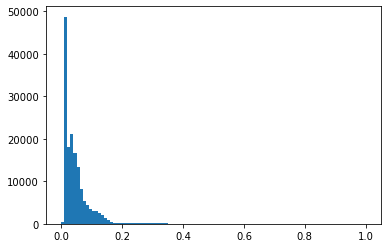

In [2]:
import matplotlib.pyplot as plt

error = df['error']
error = np.array(error)
print(np.mean(error))
plt.hist(error, bins=100, range=(0, 1))
plt.show()

In [10]:
for i in range(500, 600):
    print(df['cte'][i], df['speed(m/s)'][i], df['theta_e'][i], df['d'][i], df['dphi_t'][i], df['input'][i])

-0.03204515036384854 5.5560284457496625 -0.0001789644193583499 -16.777951404902872 1.8822324126112955e-11 -0.0007306620192293326
-0.032152188097356316 5.5560064467131545 -0.0004692489760674371 -16.777789084086084 -2.030122102173553e-11 -0.0008480712833054244
-0.03239104553351262 5.555984381560873 -0.000695617727039148 -16.777634706724164 4.440892098504661e-11 -0.0008492315813412143
-0.032656058437160615 5.555963668276967 -0.0009289105101977227 -16.777487786144288 -2.0015288331287205e-11 -0.0008179045307649355
-0.03304021014460545 5.555940184005289 -0.0011547463688861828 -16.77734931990233 -4.1491546613766074e-11 -0.0007879403838302091
-0.0335123116378844 5.555916370701896 -0.0013741910933553717 -16.777219426449562 6.459479416007237e-11 -0.000774755755702181
-0.034054755840690384 5.555896645031043 -0.001590972150842123 -16.777096634238273 -2.0157240730800553e-11 -0.0007836038450369397
-0.034657987876997254 5.55587811212756 -0.0017960356784752095 -16.77698051387233 4.119088323250972e-11 